# Section 4.5.3 Kernel ridge regression

This page contains simulations in Section 4.5.3.

## Contents

    - Classification of two-class mixture with same mean and covariance trace
    - Normal approximation of LS-SVM soft decision function $g(x)$
    - Misclassification rates on real data as a function of decision threshold $\xi$


## Classification of two-class mixture with same mean and covariance trace

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.special
import scipy.stats
from tensorflow.keras.datasets import mnist,fashion_mnist
pi = np.pi

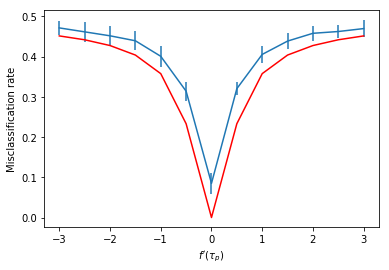

In [2]:
cs = [1/2,1/2]
k = len(cs) # number of classes
p = 512
n = 2048
n_test = 512

means = lambda i : np.zeros(p)
covs  = lambda i : scipy.linalg.toeplitz([(4*i/10)**t for t in range(p)])

Delta_means = means(0)- means(1)
Delta_covs  =  covs(0)-  covs(1)

gamma = 1
tau = 2*np.trace(cs[0]*covs(0)+cs[1]*covs(1))/p

fp_tau_loop = np.arange(-3,3.5,.5)
store_error = np.zeros( (len(fp_tau_loop),3) )

for iter,fp_tau in enumerate(fp_tau_loop):

    derivs=[4,fp_tau,2]
    coeffs=np.zeros(len(derivs))
    
    for i in range(len(derivs)):
        coeffs[i]=derivs[-i-1]/np.math.factorial(len(derivs)-i)

    f = lambda t : np.polyval(coeffs,t-tau)

    nb_average_loop = 30
    store_output = np.zeros(nb_average_loop)
    for average_index in range(nb_average_loop):
        X=np.zeros( (p,n) )
        X_test=np.zeros( (p,n_test) )
        for i in range(k):
            X[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1]*n))]=scipy.linalg.sqrtm(covs(i))@np.random.randn(p,int(cs[i]*n))+means(i).reshape(p,1)
            X_test[:,int(np.sum(cs[:i])*n_test):int(np.sum(cs[:i+1]*n_test))]=scipy.linalg.sqrtm(covs(i))@np.random.randn(p,int(cs[i]*n_test))+means(i).reshape(p,1)
  
        XX = X.T@X/p

        K = f(-2*XX+np.diag(XX).reshape(1,n)+np.diag(XX).reshape(n,1))
        y = np.concatenate([-np.ones(int(cs[0]*n)),np.ones(int(cs[1]*n))])
        y_test = np.concatenate([-np.ones(int(cs[0]*n_test)),np.ones(int(cs[1]*n_test))])

        inv_Q = K+n/gamma*np.eye(n)
        Q_y = np.linalg.solve(inv_Q,y)
        Q_1 = np.linalg.solve(inv_Q,np.ones(n))

        b = np.sum(Q_y)/np.sum(Q_1)
        alpha = Q_y-Q_1*b

        g = lambda Y : alpha@f(np.diag(XX).reshape( (n,1) )+np.diag(Y.T@Y/p).reshape( (1,np.size(Y,1)) )-2*(X.T@Y/p))+b

        g_test = g(X_test)
        store_output[average_index] = 1 - 1/n_test*(np.sum(g_test[:int(cs[0]*n_test)]<0)+np.sum(g_test[int(cs[0]*n_test):]>0))

    # theory
    D = -2*derivs[1]*np.linalg.norm(Delta_means)**2 + derivs[2]*( np.trace(Delta_covs)**2 + 2*np.trace(Delta_covs@Delta_covs) )/p
    E = lambda a : cs[1] - cs[0] + 2*(-1)**(a-1)*(1-cs[a])*gamma*cs[0]*cs[1]*D/p
    V = lambda a : 8*gamma**2*cs[0]**2*cs[1]**2*( derivs[2]**2*(np.trace(Delta_covs))**2*np.trace(covs(a)@covs(a))/p**2 + 2*derivs[1]**2*( Delta_means@covs(a)@Delta_means + np.trace( covs(a)@( covs(0)/cs[0] + covs(1)/cs[1] ) )/n ) )/p**2

    def qfunc(x):
        return 0.5-0.5*scipy.special.erf(x/np.sqrt(2))

    store_error[iter,:] = [np.mean(store_output), np.std(store_output), cs[0]*qfunc(-E(0)/np.sqrt(V(0)+1e-15)) + cs[1]*qfunc(E(1)/np.sqrt(V(1)+1e-15) )]

plt.errorbar(fp_tau_loop, store_error[:,0], store_error[:,1])
plt.plot(fp_tau_loop, store_error[:,2],'r')
plt.xlabel(r'$f^\prime(\tau_p)$')
plt.ylabel('Misclassification rate')
_ = plt.show()

## Normal approximation of LS_SVM soft decision function $g(x)$

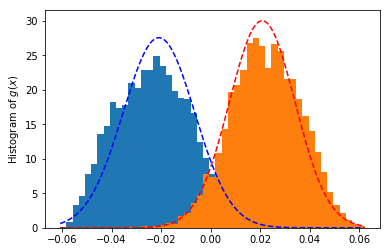

In [3]:
cs = [1/2,1/2]
k = len(cs) # number of classes
n = 2048
n_test = 512

gamma = 1 # regularization
f = lambda t : np.exp(-t/2) # RBF kernel

data_choice = 'MNIST' # MNIST or Fashion-MNIST

if data_choice == 'MNIST':
    selected_labels=[7,9]
    (init_data, init_labels), _ = mnist.load_data()

if data_choice == 'fashion':
    selected_labels=[8,9]
    (init_data, init_labels), _ = fashion_mnist.load_data()
    
idx_init_labels = np.argsort(np.array(init_labels))    
labels = init_labels[idx_init_labels]
init_data = init_data[idx_init_labels,:,:]
data = np.transpose(init_data.reshape(np.shape(init_data)[0],np.shape(init_data)[1]*np.shape(init_data)[2]))
init_n,p=np.shape(data)[1],np.shape(data)[0]

data = data/data.max()
mean_data=np.mean(data,axis=1).reshape(len(data),1)

norm2_data=0
for i in range(init_n):
    norm2_data+=1/init_n*np.linalg.norm(data[:,i]-mean_data)**2

data=(data-mean_data)/np.sqrt(norm2_data)*np.sqrt(p)

selected_data = []

for i in range(len(selected_labels)):
    selected_data.append(data[:,[ x for x in range(init_n) if labels[x]==selected_labels[i] ] ])
    if i==0:    
        cascade_selected_data = selected_data[-1]
    else:
        np.concatenate([cascade_selected_data,selected_data[-1]],axis=1)

# recentering of the k classes
mean_selected_data  = np.mean(cascade_selected_data,axis=1).reshape(len(cascade_selected_data),1)
norm2_selected_data = np.mean(np.sum(np.power(np.abs(cascade_selected_data-mean_selected_data),2),0))

for j in range(len(selected_labels)):
    selected_data[j]=(selected_data[j]-mean_selected_data)/np.sqrt(norm2_selected_data)*np.sqrt(p)

means = lambda l : np.mean(selected_data[l],axis=1)
MNIST_n = lambda l : np.shape(selected_data[l])[1]
emp_covs  = lambda l : 1/np.shape(selected_data[l])[1]*(selected_data[l]@selected_data[l].T)-np.outer(means(l),means(l))

nb_average_loop = 30

tau_estim = 0
store_output = np.zeros( (nb_average_loop,n_test) )
for average_index in range(nb_average_loop):
    X=np.zeros( (p,n) )
    X_test=np.zeros( (p,n_test) )
    for i in range(k):
        data = selected_data[i][:,np.random.permutation(np.shape(selected_data[i])[1])]
        X[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1])*n)]=data[:,:int(n*cs[i])] 
        X_test[:,int(np.sum(cs[:i])*n_test):int(np.sum(cs[:i+1])*n_test)]=data[:,n:n+int(n_test*cs[i])] 

    XX = X.T@X/p
    tau_estim += 2/n*np.trace(XX)/nb_average_loop

    K = f(-2*XX+np.diag(XX).reshape(1,n)+np.diag(XX).reshape(n,1))
    y = np.concatenate([-np.ones(int(cs[0]*n)),np.ones(int(cs[1]*n))])
    y_test = np.concatenate([-np.ones(int(cs[0]*n_test)),np.ones(int(cs[1]*n_test))])

    inv_Q = K+n/gamma*np.eye(n)
    Q_y = np.linalg.solve(inv_Q,y)
    Q_1 = np.linalg.solve(inv_Q,np.ones(n))

    b = np.sum(Q_y)/np.sum(Q_1)
    alpha = Q_y-Q_1*b

    g = lambda Y : alpha@f(np.diag(XX).reshape( (n,1) )+np.diag(Y.T@Y/p).reshape( (1,np.size(Y,1)) )-2*(X.T@Y/p))+b

    store_output[average_index,:] = g(X_test)

# theory
Delta_means = means(0) - means(1)
Delta_covs = emp_covs(0) -  emp_covs(1)
trace_delta_covs2 = np.trace(emp_covs(0)@emp_covs(0) + emp_covs(1)@emp_covs(1)) - np.trace(emp_covs(0))**2/MNIST_n(0) - np.trace(emp_covs(1))**2/MNIST_n(1) -2*np.trace(emp_covs(0)@emp_covs(1))
derivs = [f(tau_estim),-f(tau_estim)/2,f(tau_estim)/4]

#D = -2*derivs[1]*np.linalg.norm(Delta_means)**2 + derivs[2]*( np.trace(Delta_covs)**2 + 2*np.trace(Delta_covs@Delta_covs) )/p
D = -2*derivs[1]*np.linalg.norm(Delta_means)**2 + derivs[2]*( np.trace(Delta_covs)**2 + 2*trace_delta_covs2 )/p
E = lambda a : cs[1] - cs[0] + 2*(-1)**(a-1)*(1-cs[a])*gamma*cs[0]*cs[1]*D/p
V = lambda a : 8*gamma**2*cs[0]**2*cs[1]**2*( derivs[2]**2*(np.trace(Delta_covs))**2*(np.trace(emp_covs(a)@emp_covs(a)) - np.trace(emp_covs(a))**2/MNIST_n(a) )/p**2 + 2*derivs[1]**2*( Delta_means@emp_covs(a)@Delta_means + np.trace( emp_covs(a)@( emp_covs(0)/cs[0] + emp_covs(1)/cs[1] ) )/n - np.trace(emp_covs(a))**2/n**2 ) )/p**2
                                                                                                                   
xs = np.linspace(np.min(store_output.flatten()),np.max(store_output.flatten()), 200)
edges = np.linspace(np.min(store_output.flatten()),np.max(store_output.flatten()), 50)
                        
plt.hist(store_output[:,:int(cs[0]*n_test)].flatten(),bins=edges,weights=1/nb_average_loop/(cs[0]*n_test)/(edges[1]-edges[0])*np.ones(nb_average_loop*int(cs[0]*n_test)))
plt.hist(store_output[:,int(cs[0]*n_test):].flatten(),bins=edges,weights=1/nb_average_loop/(cs[1]*n_test)/(edges[1]-edges[0])*np.ones(nb_average_loop*int(cs[1]*n_test)))
E0,E1,V0,V1 = E(0),E(1),V(0),V(1)
plt.plot(xs,[scipy.stats.norm.pdf(x,E0,np.sqrt(V0)) for x in xs],'b--')
plt.plot(xs,[scipy.stats.norm.pdf(x,E1,np.sqrt(V1)) for x in xs],'r--')
plt.ylabel(r'Histogram of $g(x)$')
_ = plt.show()

## Misclassification rates on real data as a function of decision threshold $\xi$

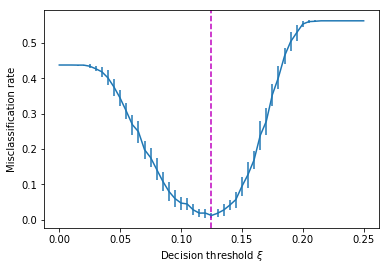

In [4]:
cs = [7/16,9/16]
k = len(cs)  # number of classes
n = 512
n_test = 128

gamma = 1  # regularization
f = lambda t : np.exp(-t/2) # RBF kernel

xi_loop = np.arange(0,0.25005,0.005)
store_error = np.zeros( (len(xi_loop),2) )

data_choice = 'MNIST'  # MNIST or Fashion-MNIST

if data_choice == 'MNIST':
    selected_labels=[7,9]
    (init_data, init_labels), _ = mnist.load_data()

if data_choice == 'fashion':
    selected_labels=[8,9]
    (init_data, init_labels), _ = fashion_mnist.load_data()
    
idx_init_labels = np.argsort(np.array(init_labels))    
labels = init_labels[idx_init_labels]
init_data = init_data[idx_init_labels,:,:]
data = np.transpose(init_data.reshape(np.shape(init_data)[0],np.shape(init_data)[1]*np.shape(init_data)[2]))
init_n,p=np.shape(data)[1],np.shape(data)[0]

selected_labels=[3,4]

data = data/data.max()
mean_data=np.mean(data,axis=1).reshape(len(data),1)

norm2_data=0
for i in range(init_n):
    norm2_data+=1/init_n*np.linalg.norm(data[:,i]-mean_data)**2

data=(data-mean_data)/np.sqrt(norm2_data)*np.sqrt(p)

selected_data = []

for i in range(len(selected_labels)):
    selected_data.append(data[:,[ x for x in range(init_n) if labels[x]==selected_labels[i] ] ])
    if i==0:    
        cascade_selected_data = selected_data[-1]
    else:
        np.concatenate([cascade_selected_data,selected_data[-1]],axis=1)

# recentering of the k classes
mean_selected_data  = np.mean(cascade_selected_data,axis=1).reshape(len(cascade_selected_data),1)
norm2_selected_data = np.mean(np.sum(np.power(np.abs(cascade_selected_data-mean_selected_data),2),0))

for j in range(len(selected_labels)):
    selected_data[j]=(selected_data[j]-mean_selected_data)/np.sqrt(norm2_selected_data)*np.sqrt(p)

for iter,xi in enumerate(xi_loop):

    nb_average_loop = 30
    store_output = np.zeros(nb_average_loop)
    for  average_index in range(nb_average_loop):
        X=np.zeros( (p,n) )
        X_test=np.zeros( (p,n_test) )
        for i in range(k):
            data = selected_data[i][:,np.random.permutation(np.shape(selected_data[i])[1])]
            X[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1])*n)]=data[:,:int(n*cs[i])] 
            X_test[:,int(np.sum(cs[:i])*n_test):int(np.sum(cs[:i+1])*n_test)]=data[:,n:n+int(n_test*cs[i])] 

        XX = X.T@X/p
        
        K = f(-2*XX+np.diag(XX).reshape(1,n)+np.diag(XX).reshape(n,1))
        y = np.concatenate([-np.ones(int(cs[0]*n)),np.ones(int(cs[1]*n))])
        y_test = np.concatenate([-np.ones(int(cs[0]*n_test)),np.ones(int(cs[1]*n_test))])

        inv_Q = K+n/gamma*np.eye(n)
        Q_y = np.linalg.solve(inv_Q,y)
        Q_1 = np.linalg.solve(inv_Q,np.ones(n))

        b = np.sum(Q_y)/np.sum(Q_1)
        alpha = Q_y-Q_1*b

        g = lambda Y : alpha@f(np.diag(XX).reshape( (n,1) )+np.diag(Y.T@Y/p).reshape( (1,np.size(Y,1)) )-2*(X.T@Y/p))+b

        g_test = g(X_test)

        store_output[average_index] = 1 - 1/n_test*(np.sum(g_test[:int(cs[0]*n_test)]<xi)+np.sum(g_test[int(cs[0]*n_test):]>xi))

    store_error[iter,:] = [np.mean(store_output),np.std(store_output)]

plt.errorbar(xi_loop, store_error[:,0], store_error[:,1])
plt.axvline(cs[1]-cs[0],ls='--',color='m')
plt.xlabel(r'Decision threshold $\xi$')
plt.ylabel('Misclassification rate')
_ = plt.show()